<a href="https://colab.research.google.com/github/junting-huang/kinglear_rag/blob/main/rag_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.0 Set-up

In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.84.0
    Uninstalling openai-1.84.0:
      Successfully uninstalled openai-1.84.0


In [ ]:
from openai import OpenAI

client = OpenAI(api_key="OPENAI_API_KEY")

#1.0 Referential Accuracy (%)

## 1.1 Initial Test (All Questions)

In [ ]:
import pandas as pd

# Load files
answers_df = pd.read_csv("rag-generate.tsv", sep="\t")
lear_df = pd.read_csv("kinglear.tsv", sep="\t")

# Complete question map
question_map = {
    "1f": "What does Lear ask his daughters to do before dividing the kingdom?",
    "1a": "Is Lear demanding love out of senility and childishness, seeking a symbolic display of loyalty? Or is he driven by shame and fear of real love, preferring performative affection because true love requires a reciprocity he can't manage?",
    "1cf": "What if Lear had not framed the division as a contest of love declarations? What might have been his alternative approach to succession?",
    "2f": "What is Cordelia’s response to Lear’s request for a love declaration?",
    "2a": "Is Cordelia being deliberately defiant, standing for truth over flattery? Or is her refusal simply an honest struggle to express love falsely, hiding deep affection rather than rebelling?",
    "2cf": "What if Cordelia had tried to explain her concept of love more clearly to Lear? What would make her help Lear understand that love is deeper than words?",
    "3f": "Who is responsible for blinding Gloucester, and what is their motivation?",
    "3a": "Does Gloucester’s blinding symbolize his moral blindness, highlighting human cruelty and vulnerability? Or is it a metaphor for cruelty’s desire to stay hidden, linked to Gloucester’s own shame and refusal to acknowledge Edmund?",
    "3cf": "What if Gloucester had been spared from blinding but was forced to witness others suffer? How might he respond to suffering and cruelty?",
    "4f": "When Gloucester expresses remorse about Edgar, what identity does Edgar maintain?",
    "4a": "Does Edgar delay revealing himself to test Gloucester’s repentance and heighten the drama? Or does his avoidance reveal emotional cruelty, reflecting a broader theme of avoiding mutual recognition?",
    "4cf": "What if Edgar had revealed his identity to Gloucester earlier? What would make him trust his father enough to disclose the truth without prolonging the disguise?",
    "5f": "What is the last scene in which the Fool appears?",
    "5a": "Does the Fool serve as Lear’s conscience and disappear as Lear descends into madness? Or does he vanish because his truth-telling becomes too painful, exposing a shame Lear can no longer bear?",
    "5cf": "What if the Fool had stayed with Lear throughout his madness? What might he say to Lear in his darkest moments?",
    "6f": "How does Cordelia die, and who is directly responsible for her death?",
    "6a": "Is Cordelia’s death presented as the result of political betrayal, highlighting chaos and the absence of justice? Or is it the inevitable cost of Lear’s emotional failure—his inability to accept real love?",
    "6cf": "What if Lear had arrived moments earlier and saved Cordelia? What circumstances would need to change for Cordelia’s rescue to be possible?"
}

# Context retrieval
def retrieve_context(question, lear_df, top_n=5):
    return lear_df[lear_df['turn_text'].str.contains('|'.join(question.split()), case=False, na=False)].head(top_n)

# Evaluate referential accuracy
def check_accuracy(question, answer, context_df):
    context = "\n".join(f"{row['speaker']}: {row['turn_text']}" for _, row in context_df.iterrows())
    prompt = f"""You are a literary expert in Shakespeare.

Question: {question}
Answer: {answer}

Relevant passages from King Lear:
{context}

Does the answer correctly reference the context and address the question?
Reply with a single digit: 1 (accurate) or 0 (inaccurate)."""

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        result = response.choices[0].message.content.strip()
        return int(result[0]) if result[0] in ['0', '1'] else 0
    except Exception as e:
        print(f"Error at row: {e}")
        return 0

# Add accuracy scores
question_texts = []
accuracy_scores = []

for _, row in answers_df.iterrows():
    q_key = f"{row['question_num']}{row['category']}"
    question = question_map.get(q_key)

    if question is None:
        print(f"Missing mapping for {q_key}")
        question_texts.append("N/A")
        accuracy_scores.append(0)
        continue

    question_texts.append(question)
    context = retrieve_context(question, lear_df)
    score = check_accuracy(question, row['answer'], context)
    accuracy_scores.append(score)

# Append new columns
answers_df["question_text"] = question_texts
answers_df["accuracy"] = accuracy_scores

# Export to new TSV
answers_df.to_csv("rag-generate_with_accuracy.tsv", sep="\t", index=False)

    question_num category  accuracy
0              1        a      0.32
1              1       cf      0.72
2              1        f      0.24
3              2        a      0.38
4              2       cf      0.24
5              2        f      0.40
6              3        a      0.80
7              3       cf      0.30
8              3        f      0.00
9              4        a      0.46
10             4       cf      0.54
11             4        f      0.34
12             5        a      0.32
13             5       cf      0.42
14             5        f      0.42
15             6        a      0.70
16             6       cf      0.16
17             6        f      0.00


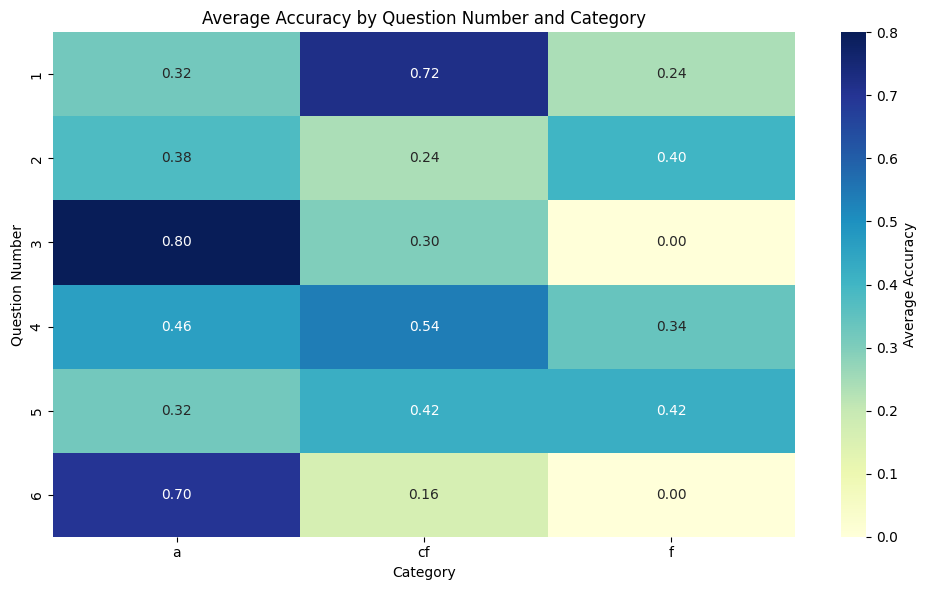

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the TSV file
file_path = "rag-generate_with_accuracy.tsv"  # Adjust path if needed
df = pd.read_csv(file_path, sep="\t")

# Compute average accuracy grouped by question number and category
grouped_accuracy = df.groupby(['question_num', 'category'])['accuracy'].mean().reset_index()

# Pivot for heatmap-style display
pivot_df = grouped_accuracy.pivot(index='question_num', columns='category', values='accuracy')

# Optional: print the grouped accuracy table
print(grouped_accuracy)

# Visualize with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Accuracy'}, fmt=".2f")
plt.title("Average Accuracy by Question Number and Category")
plt.ylabel("Question Number")
plt.xlabel("Category")
plt.tight_layout()
plt.show()

Test Result: [rag-generate_with_accuracy.tsv](https://drive.google.com/file/d/1h0EAqDeN1GQFsBrEVsw8zijrvEsgJH1J/view?usp=drive_link)

## 1.2 RAG vs Non-RAG (F Category Question)

     source  accuracy
0  Baseline  0.130000
1       RAG  0.103333


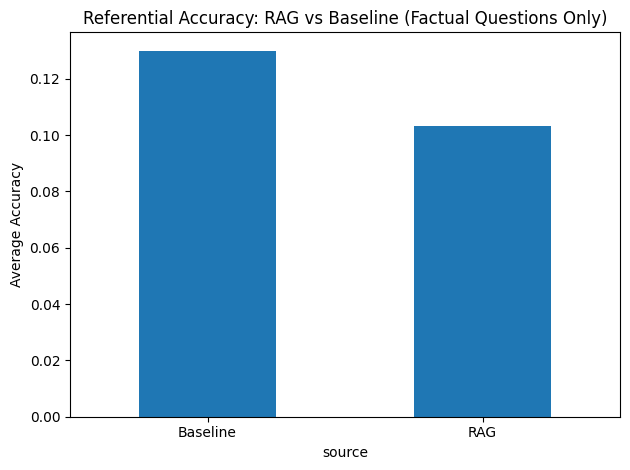

In [ ]:
import pandas as pd
from openai import OpenAI
import matplotlib.pyplot as plt

# Load data
rag_df = pd.read_csv("rag-generate.tsv", sep="\t")
null_df = pd.read_csv("null-generate.tsv", sep="\t")
lear_df = pd.read_csv("kinglear.tsv", sep="\t")

# Filter only F category from RAG
rag_df = rag_df[rag_df['category'] == 'f'].copy()
rag_df["source"] = "RAG"

# Use all entries from Baseline (null)
null_df = null_df[null_df['category'] == 'f'].copy()
null_df["source"] = "Baseline"

# Combine both
combined_df = pd.concat([rag_df, null_df], ignore_index=True)

# Factual questions only
question_map = {
    "1f": "What does Lear ask his daughters to do before dividing the kingdom?",
    "2f": "What is Cordelia’s response to Lear’s request for a love declaration?",
    "3f": "Who is responsible for blinding Gloucester, and what is their motivation?",
    "4f": "When Gloucester expresses remorse about Edgar, what identity does Edgar maintain?",
    "5f": "What is the last scene in which the Fool appears?",
    "6f": "How does Cordelia die, and who is directly responsible for her death?"
}


# Context retrieval
def retrieve_context(question, lear_df, top_n=5):
    return lear_df[lear_df['turn_text'].str.contains('|'.join(question.split()), case=False, na=False)].head(top_n)

# Updated accuracy prompt
def check_accuracy(question, answer, context_df):
    context = "\n".join(f"{row['speaker']}: {row['turn_text']}" for _, row in context_df.iterrows())
    prompt = f"""You are a literary expert in Shakespeare. Avoid unnecessary words in your responses. Use simple, direct language.

Your task is to evaluate whether the following answer accurately cites or paraphrases relevant textual content from *King Lear* in response to a factual or context-specific question.

A response is marked “accurate” if it contains content that is directly traceable to the play and correctly describes events, characters, or actions. Only return results without any additional commentary or formatting.

Question: {question}
Answer: {answer}

Relevant excerpts from King Lear:
{context}

Does the answer correctly cite or paraphrase the relevant textual content and accurately describe what happens in the play?

Reply with a single digit: 1 (accurate) or 0 (inaccurate)."""

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        result = response.choices[0].message.content.strip()
        return int(result[0]) if result[0] in ['0', '1'] else 0
    except Exception as e:
        print(f"Error at row: {e}")
        return 0

# Run accuracy checks
question_texts = []
accuracy_scores = []

for _, row in combined_df.iterrows():
    q_key = f"{row['question_num']}{row['category']}"
    question = question_map.get(q_key)

    if question is None:
        question_texts.append("N/A")
        accuracy_scores.append(0)
        continue

    question_texts.append(question)
    context = retrieve_context(question, lear_df)
    score = check_accuracy(question, row['answer'], context)
    accuracy_scores.append(score)

# Save results
combined_df["question_text"] = question_texts
combined_df["accuracy"] = accuracy_scores
combined_df.to_csv("combined_accuracy_evaluation.tsv", sep="\t", index=False)

# Summary statistics
summary = combined_df.groupby("source")["accuracy"].mean().reset_index()
print(summary)

# Bar chart
summary.plot(kind="bar", x="source", y="accuracy", legend=False)
plt.ylabel("Average Accuracy")
plt.title("Referential Accuracy: RAG vs Baseline (Factual Questions Only)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Test Result: [combined_accuracy_evaluation.tsv](https://drive.google.com/file/d/1h0EAqDeN1GQFsBrEVsw8zijrvEsgJH1J/view?usp=drive_link)

#2.0 Choice Classification (A Category Question)

In [ ]:
import pandas as pd
from openai import OpenAI

# Load TSV files
answers_df = pd.read_csv("rag-generate.tsv", sep="\t")
lear_df = pd.read_csv("kinglear.tsv", sep="\t")

# Filter only A-category rows
answers_df = answers_df[answers_df["category"] == "a"]

# Define A-category questions with two options embedded
question_map = {
    "1a": "Is Lear demanding love out of senility and childishness, seeking a symbolic display of loyalty? (A) Or is he driven by shame and fear of real love, preferring performative affection because true love requires a reciprocity he can't manage? (B)",
    "2a": "Is Cordelia being deliberately defiant, standing for truth over flattery? (A) Or is her refusal simply an honest struggle to express love falsely, hiding deep affection rather than rebelling? (B)",
    "3a": "Does Gloucester’s blinding symbolize his moral blindness, highlighting human cruelty and vulnerability? (A) Or is it a metaphor for cruelty’s desire to stay hidden, linked to Gloucester’s own shame and refusal to acknowledge Edmund? (B)",
    "4a": "Does Edgar delay revealing himself to test Gloucester’s repentance and heighten the drama? (A) Or does his avoidance reveal emotional cruelty, reflecting a broader theme of avoiding mutual recognition? (B)",
    "5a": "Does the Fool serve as Lear’s conscience and disappear as Lear descends into madness? (A) Or does he vanish because his truth-telling becomes too painful, exposing a shame Lear can no longer bear? (B)",
    "6a": "Is Cordelia’s death presented as the result of political betrayal, highlighting chaos and the absence of justice? (A) Or is it the inevitable cost of Lear’s emotional failure—his inability to accept real love? (B)"
}

# Function to classify answer alignment
def classify_answer(question, answer):
    prompt = f"""You are a literary expert in Shakespeare.

QUESTION:
{question}

ANSWER:
{answer}

Does the answer align more with Option A, Option B, both (A+B), or neither (N/A)? Reply with one of: A, B, A+B, or N/A."""

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        result = response.choices[0].message.content.strip()
        result_upper = result.upper()
        if result_upper in ["A", "B", "A+B", "N/A"]:
            return result_upper
        return "N/A"
    except Exception as e:
        print(f"Error at row: {e}")
        return "N/A"

# Process and classify answers
question_texts = []
classifications = []

for _, row in answers_df.iterrows():
    q_code = f"{row['question_num']}{row['category']}"
    question = question_map.get(q_code)

    if not question:
        question_texts.append("N/A")
        classifications.append("N/A")
        continue

    question_texts.append(question)
    label = classify_answer(question, row['answer'])
    classifications.append(label)

# Add results to DataFrame and export
answers_df["question_text"] = question_texts
answers_df["classification"] = classifications
answers_df.to_csv("rag-generate_a_classified.tsv", sep="\t", index=False)

Classification Tally by Question Number:
classification   A  A+B   B
question_num               
1                2   30  18
2                3    4  42
3                3   45   2
4               11   24  15
5                2   29  19
6                0   12  38


<Figure size 1000x600 with 0 Axes>

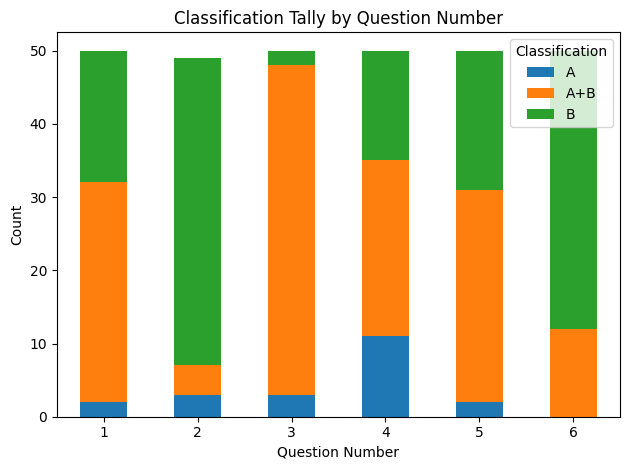

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the TSV file
file_path = "rag-generate_a_classified.tsv"  # Update path if needed
df = pd.read_csv(file_path, sep="\t")

# Group and tally classifications by question number
classification_tally = df.groupby("question_num")["classification"].value_counts().unstack().fillna(0).astype(int)

# Print the tally table
print("Classification Tally by Question Number:")
print(classification_tally)

# Plot the results
plt.figure(figsize=(10, 6))
classification_tally.plot(kind='bar', stacked=True)
plt.title("Classification Tally by Question Number")
plt.xlabel("Question Number")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Classification")
plt.tight_layout()
plt.show()

Test Result: [rag-generate_a_classified.tsv](https://drive.google.com/file/d/1h0EAqDeN1GQFsBrEVsw8zijrvEsgJH1J/view?usp=drive_link)

#3.0 Retrieval Relevance (A Category Question)

| **Quote Set**              | **Quotes Provided** | **Quotes Found** | **Key Observations**                                                             |
| -------------------------- | ------------------- | ---------------- | -------------------------------------------------------------------------------- |
| Lear (1)             | 10                  | 1                | Only "I'll not love. Read thou this challenge..." (Act IV, vi) appears.          |
| Cordelia (2)       | 10                  | 3                | Focus on early scenes ("What shall Cordelia speak?", "Unhappy that I am...").    |
| Gloucester (3)     | 10                  | 1                | Only "What, with the case of eyes?" (Act IV, vi) is quoted.                      |
| Gloucester/Edgar (4)          | 10                  | 0                | No quotes from later subplot scenes (e.g., Dover Cliff, Edgar’s disguise).       |
| Fool-Related (5)              | 10                  | 1                | Only "I'll weep. O fool, I shall go mad!" (Act II, iv) referenced.               |
| Cordelia/Lear (6) | 10                  | 3                | Early exchanges ("Unhappy that I am...", "So young, and so untender?") analyzed. |


Generally about 1-3 quotes appear in Cavell's text, but this may need manually sourced or abandoned altogether...

#4.0 Response Consistency (Δ)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# === Step 1: Load Data ===
# Replace with your file path
file_path = 'rag-generate.tsv'
df = pd.read_csv(file_path, sep='\t', header=None)

# Rename columns for clarity
df.columns = ['question', 'type', 'run', 'response']

# Create a category identifier like '1f', '2cf', etc.
df['category'] = df['question'].astype(str) + df['type']

# === Step 2: Define Δ Computation Function ===
def compute_delta_tfidf(responses):
    """Compute 1 - avg pairwise cosine similarity of TF-IDF vectors."""
    if len(responses) < 2:
        return np.nan  # Not enough data to compute
    vectorizer = TfidfVectorizer().fit_transform(responses)
    sim_matrix = cosine_similarity(vectorizer)
    triu_indices = np.triu_indices(len(responses), k=1)
    avg_similarity = np.mean(sim_matrix[triu_indices])
    return 1 - avg_similarity

# === Step 3: Group and Compute Consistency Scores ===
delta_scores = df.groupby('category')['response'].apply(compute_delta_tfidf).reset_index()
delta_scores.columns = ['Category', 'Response Consistency (Δ)']

# === Step 4: Save or Display the Results ===
print(delta_scores)

# Optionally, save to CSV
delta_scores.to_csv('response_consistency_scores.csv', index=False)


   Category  Response Consistency (Δ)
0        1a                  0.658775
1       1cf                  0.655613
2        1f                  0.673069
3        2a                  0.639870
4       2cf                  0.656151
5        2f                  0.641235
6        3a                  0.616508
7       3cf                  0.654387
8        3f                  0.691999
9        4a                  0.681840
10      4cf                  0.680818
11       4f                  0.675998
12       5a                  0.586091
13      5cf                  0.646638
14       5f                  0.637800
15       6a                  0.633689
16      6cf                  0.671199
17       6f                  0.683327


#5.0 Interpretive Depth (Avg 1–5)

to be manually sourced ...